In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
%cd /content/drive/MyDrive/tenx/Fraud_Detection_For_E_commerce_and_Bank_Transactions/notebooks

/content/drive/MyDrive/tenx/Fraud_Detection_For_E_commerce_and_Bank_Transactions/notebooks


### **Model Building and Training**

**Import Libraries**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, auc


# Data Preparation

In [13]:
fraud_data_df = pd.read_csv('../Data/raw/Fraud_Data.csv')


In [14]:

print("\n--- Preparing data for Fraud_Data.csv models ---")
X_fraud = fraud_data_df.drop('class', axis=1)
y_fraud = fraud_data_df['class']
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
) # [26, 27]
print(f"Fraud_Data.csv train/test split shapes: X_train:{X_train_fraud.shape}, y_train:{y_train_fraud.shape}, X_test:{X_test_fraud.shape}, y_test:{y_test_fraud.shape}")





--- Preparing data for Fraud_Data.csv models ---
Fraud_Data.csv train/test split shapes: X_train:(120889, 10), y_train:(120889,), X_test:(30223, 10), y_test:(30223,)


# Handling class imbalance

In [15]:
#  Handle Class Imbalance - SMOTE for Fraud_Data.csv
print("Applying SMOTE to Fraud_Data.csv training data...")
smote_fraud = SMOTE(random_state=42)
X_train_fraud = X_train_fraud.select_dtypes(include=['number'])
X_train_fraud_resampled, y_train_fraud_resampled = smote_fraud.fit_resample(X_train_fraud, y_train_fraud)
print(f"Fraud_Data.csv training data class distribution before SMOTE:\n{y_train_fraud.value_counts()}")
print(f"Fraud_Data.csv training data class distribution after SMOTE:\n{y_train_fraud_resampled.value_counts()}")

Applying SMOTE to Fraud_Data.csv training data...
Fraud_Data.csv training data class distribution before SMOTE:
class
0    109568
1     11321
Name: count, dtype: int64
Fraud_Data.csv training data class distribution after SMOTE:
class
0    109568
1    109568
Name: count, dtype: int64


In [16]:
# Data Preparation - Train-Test Split for creditcard.csv
creditcard_df = pd.read_csv('../Data/raw/creditcard.csv')
print("\n--- Preparing data for creditcard.csv models ---")
X_cc = creditcard_df.drop('Class', axis=1)
y_cc = creditcard_df['Class']
X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(
    X_cc, y_cc, test_size=0.2, random_state=42, stratify=y_cc)
print(f"creditcard.csv train/test split shapes: X_train:{X_train_cc.shape}, y_train:{y_train_cc.shape}, X_test:{X_test_cc.shape}, y_test:{y_test_cc.shape}")


--- Preparing data for creditcard.csv models ---
creditcard.csv train/test split shapes: X_train:(227845, 30), y_train:(227845,), X_test:(56962, 30), y_test:(56962,)


# Handle Class Imbalance for creditcard

In [17]:
# Handle Class Imbalance - SMOTE for creditcard.csv
print("Applying SMOTE to creditcard.csv training data...")
smote_cc = SMOTE(random_state=42)
X_train_cc = X_train_cc.select_dtypes(include=['number'])
X_train_cc_resampled, y_train_cc_resampled = smote_cc.fit_resample(X_train_cc, y_train_cc)
print(f"creditcard.csv training data class distribution before SMOTE:\n{y_train_cc.value_counts()}")
print(f"creditcard.csv training data class distribution after SMOTE:\n{y_train_cc_resampled.value_counts()}")

Applying SMOTE to creditcard.csv training data...
creditcard.csv training data class distribution before SMOTE:
Class
0    227451
1       394
Name: count, dtype: int64
creditcard.csv training data class distribution after SMOTE:
Class
0    227451
1    227451
Name: count, dtype: int64


# Model Training and Evaluation Function

In [25]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name, dataset_name):
    print(f"\n--- Training and Evaluating {model_name} on {dataset_name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f"Classification Report for {model_name} on {dataset_name}:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {model_name} on {dataset_name}:")
    print(cm)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
                cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=["Non-fraudulent", "Fraudulent"],
                yticklabels=["Non-fraudulent", "Fraudulent"],
            )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model} on {dataset_name} set")
    plt.show()
    # Calculate AUC-PR
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = auc(recall, precision)
    print(f"AUC-PR for {model_name} on {dataset_name}: {auc_pr}")
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score for {model_name} on {dataset_name}: {f1}")



    return model, y_pred, y_proba, auc_pr, f1, cm


# **Model Selection and Training**

In [20]:
# Models to compare
logistic_regression_model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced') # [37, 38, 39, 40]
xgboost_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y_train_fraud_resampled) - y_train_fraud_resampled.sum()) / y_train_fraud_resampled.sum()) # [41, 42, 43, 44]



# Train and evaluate on Fraud_Data


--- Training and Evaluating Logistic Regression on Fraud_Data.csv ---
Classification Report for Logistic Regression on Fraud_Data.csv:
              precision    recall  f1-score   support

           0       0.91      0.54      0.68     27393
           1       0.10      0.47      0.16      2830

    accuracy                           0.54     30223
   macro avg       0.50      0.51      0.42     30223
weighted avg       0.83      0.54      0.63     30223

Confusion Matrix for Logistic Regression on Fraud_Data.csv:
[[14904 12489]
 [ 1488  1342]]


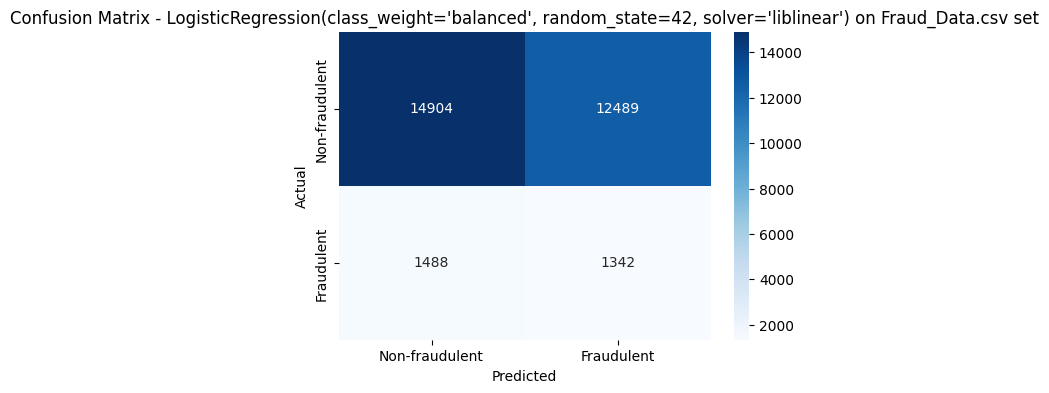

AUC-PR for Logistic Regression on Fraud_Data.csv: 0.09514652812582572
F1 Score for Logistic Regression on Fraud_Data.csv: 0.16109477222255567

--- Training and Evaluating XGBoost on Fraud_Data.csv ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:18:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report for XGBoost on Fraud_Data.csv:
              precision    recall  f1-score   support

           0       0.94      0.69      0.80     27393
           1       0.17      0.60      0.26      2830

    accuracy                           0.68     30223
   macro avg       0.56      0.65      0.53     30223
weighted avg       0.87      0.68      0.75     30223

Confusion Matrix for XGBoost on Fraud_Data.csv:
[[19005  8388]
 [ 1142  1688]]


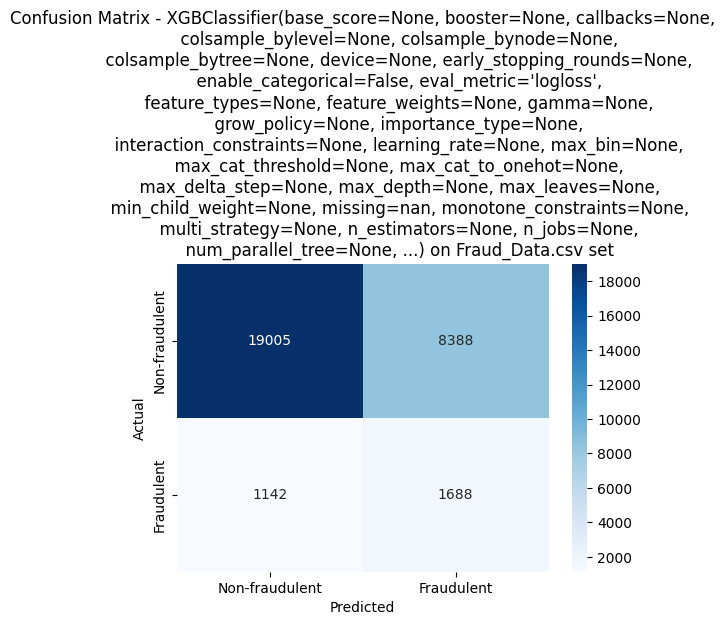

AUC-PR for XGBoost on Fraud_Data.csv: 0.32663202472506003
F1 Score for XGBoost on Fraud_Data.csv: 0.26158375949170926


In [26]:
# Select only numerical columns from X_test_fraud
X_test_fraud_numerical = X_test_fraud.select_dtypes(include=['number'])

lr_fraud_model, lr_fraud_pred, lr_fraud_proba, lr_fraud_auc_pr, lr_fraud_f1, lr_fraud_cm = train_and_evaluate_model(
    logistic_regression_model, X_train_fraud_resampled, y_train_fraud_resampled, X_test_fraud_numerical, y_test_fraud,
    "Logistic Regression", "Fraud_Data.csv"
)

xg_fraud_model, xg_fraud_pred, xg_fraud_proba, xg_fraud_auc_pr, xg_fraud_f1, xg_fraud_cm = train_and_evaluate_model(
    xgboost_model, X_train_fraud_resampled, y_train_fraud_resampled, X_test_fraud_numerical, y_test_fraud,
    "XGBoost", "Fraud_Data.csv"
)

# Train and evaluate on creditcard


--- Training and Evaluating Logistic Regression on creditcard.csv ---
Classification Report for Logistic Regression on creditcard.csv:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.91      0.14        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962

Confusion Matrix for Logistic Regression on creditcard.csv:
[[55739  1125]
 [    9    89]]


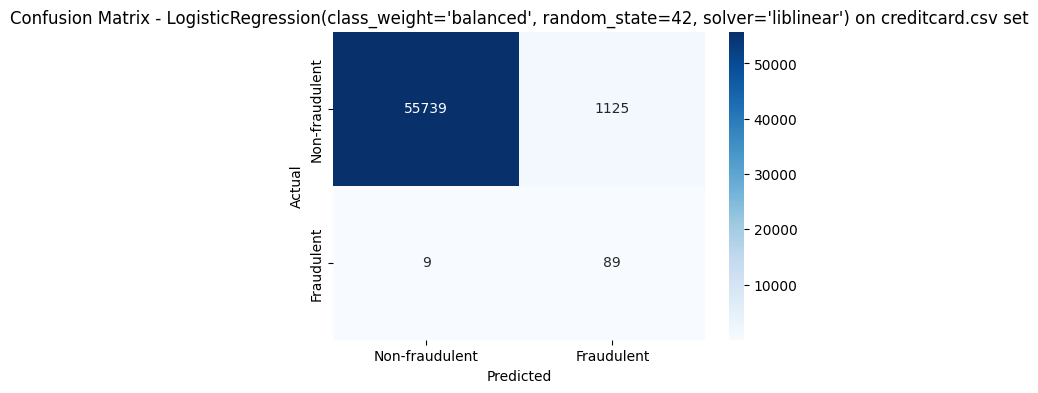

AUC-PR for Logistic Regression on creditcard.csv: 0.7088447457282776
F1 Score for Logistic Regression on creditcard.csv: 0.13567073170731708

--- Training and Evaluating XGBoost on creditcard.csv ---


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:18:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report for XGBoost on creditcard.csv:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.79      0.85      0.82        98

    accuracy                           1.00     56962
   macro avg       0.90      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix for XGBoost on creditcard.csv:
[[56842    22]
 [   15    83]]


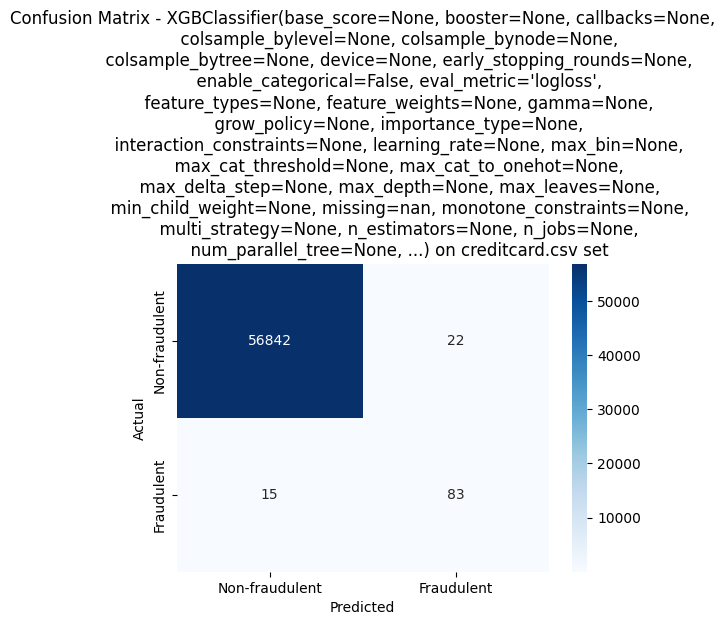

AUC-PR for XGBoost on creditcard.csv: 0.8669421230970981
F1 Score for XGBoost on creditcard.csv: 0.8177339901477833


In [27]:
# Re-initialize XGBoost model for creditcard.csv with its specific scale_pos_weight
xgboost_model_cc = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y_train_cc_resampled) - y_train_cc_resampled.sum()) / y_train_cc_resampled.sum())

lr_cc_model, lr_cc_pred, lr_cc_proba, lr_cc_auc_pr, lr_cc_f1, lr_cc_cm = train_and_evaluate_model(
    logistic_regression_model, X_train_cc_resampled, y_train_cc_resampled, X_test_cc, y_test_cc,
    "Logistic Regression", "creditcard.csv"
)

xg_cc_model, xg_cc_pred, xg_cc_proba, xg_cc_auc_pr, xg_cc_f1, xg_cc_cm = train_and_evaluate_model(
    xgboost_model_cc, X_train_cc_resampled, y_train_cc_resampled, X_test_cc, y_test_cc,
    "XGBoost", "creditcard.csv"
)

# **Justify Best Model**

In [28]:
print("\n--- Model Selection Justification ---")
print(f"Comparing models based on AUC-PR and F1-Score:")
print(f"Fraud_Data.csv - Logistic Regression: AUC-PR={lr_fraud_auc_pr:.4f}, F1={lr_fraud_f1:.4f}")
print(f"Fraud_Data.csv - XGBoost: AUC-PR={xg_fraud_auc_pr:.4f}, F1={xg_fraud_f1:.4f}")
print(f"creditcard.csv - Logistic Regression: AUC-PR={lr_cc_auc_pr:.4f}, F1={lr_cc_f1:.4f}")
print(f"creditcard.csv - XGBoost: AUC-PR={xg_cc_auc_pr:.4f}, F1={xg_cc_f1:.4f}")




--- Model Selection Justification ---
Comparing models based on AUC-PR and F1-Score:
Fraud_Data.csv - Logistic Regression: AUC-PR=0.0951, F1=0.1611
Fraud_Data.csv - XGBoost: AUC-PR=0.3266, F1=0.2616
creditcard.csv - Logistic Regression: AUC-PR=0.7088, F1=0.1357
creditcard.csv - XGBoost: AUC-PR=0.8669, F1=0.8177
